In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/datasets/global-temp/master/data/monthly.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-04-08 07:37:26--  https://raw.githubusercontent.com/datasets/global-temp/master/data/monthly.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69029 (67K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  67.41K  --.-KB/s    in 0.002s  

2020-04-08 07:37:28 (37.7 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [69029/69029]



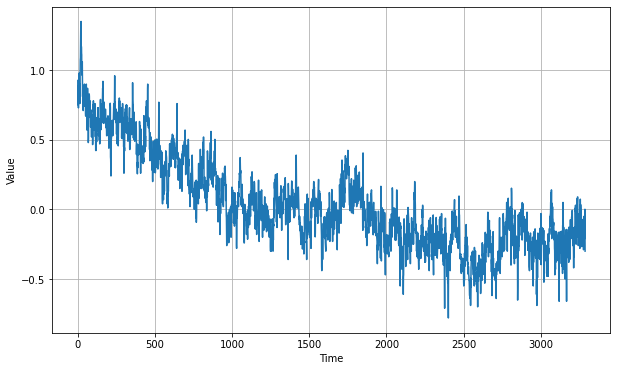

In [15]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[2]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time,series)

In [0]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
25/25 [==============================] - 0s 16ms/step - loss: 0.8086 - mae: 1.1863 - lr: 1.0000e-08
Epoch 2/100
25/25 [==============================] - 0s 15ms/step - loss: 0.7037 - mae: 1.0731 - lr: 1.1220e-08
Epoch 3/100
25/25 [==============================] - 0s 15ms/step - loss: 0.6070 - mae: 0.9632 - lr: 1.2589e-08
Epoch 4/100
25/25 [==============================] - 0s 16ms/step - loss: 0.5224 - mae: 0.8683 - lr: 1.4125e-08
Epoch 5/100
25/25 [==============================] - 0s 16ms/step - loss: 0.4523 - mae: 0.7925 - lr: 1.5849e-08
Epoch 6/100
25/25 [==============================] - 0s 17ms/step - loss: 0.4003 - mae: 0.7358 - lr: 1.7783e-08
Epoch 7/100
25/25 [==============================] - 0s 17ms/step - loss: 0.3615 - mae: 0.6945 - lr: 1.9953e-08
Epoch 8/100
25/25 [==============================] - 0s 17ms/step - loss: 0.3315 - mae: 0.6675 - lr: 2.2387e-08
Ep

(1e-08, 0.0001, 0.0, 60.0)

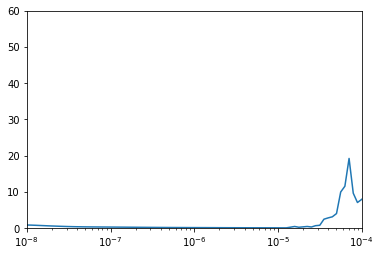

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=200, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1.1220e-05, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
13/13 [==============================] - 0s 14ms/step - loss: 0.7136 - mae: 1.1593
Epoch 2/150
13/13 [==============================] - 0s 16ms/step - loss: 0.1972 - mae: 0.5111
Epoch 3/150
13/13 [==============================] - 0s 21ms/step - loss: 0.1003 - mae: 0.3692
Epoch 4/150
13/13 [==============================] - 0s 16ms/step - loss: 0.0837 - mae: 0.3514
Epoch 5/150
13/13 [==============================] - 0s 18ms/step - loss: 0.0513 - mae: 0.2583
Epoch 6/150
13/13 [==============================] - 0s 19ms/step - loss: 0.0263 - mae: 0.1810
Epoch 7/150
13/13 [==============================] - 0s 17ms/step - loss: 0.0209 - mae: 0.1561
Epoch 8/150
13/13 [==============================] - 0s 16ms/step - loss: 0.0284 - mae: 0.1895
Epoch 9/150
13/13 [==============================] - 0s 19ms/step - loss: 0.0293 - mae: 0.1972
Epoch 10/150
13/13 [==============================] - 0s 20ms/step - loss: 0.0223 - mae: 0.1652
Epoch 11/150
13/13 [=============================

In [0]:
forecasts = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

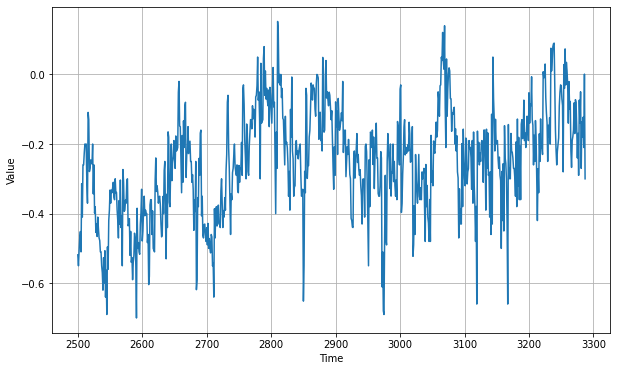

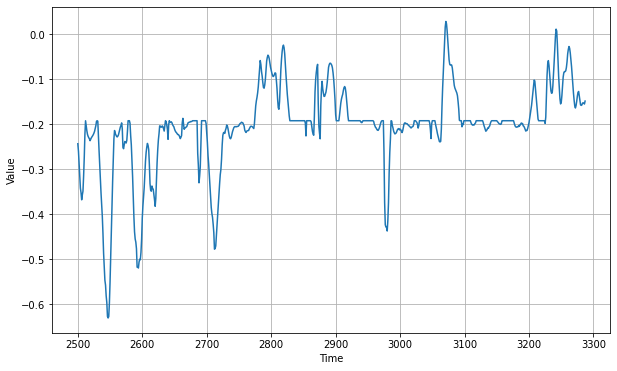

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.figure(figsize=(10, 6))
plot_series(time_valid, rnn_forecast)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.10595643

In [23]:
print(rnn_forecast)

[-0.24306215 -0.2596366  -0.28790465 -0.3193462  -0.34179276 -0.3518296
 -0.36765268 -0.3567996  -0.34838197 -0.31474704 -0.27370006 -0.22221783
 -0.19197412 -0.20326078 -0.21393327 -0.2221501  -0.2265563  -0.22967863
 -0.23210768 -0.23624319 -0.23317002 -0.22979495 -0.22770944 -0.22529198
 -0.22276118 -0.2194364  -0.21536623 -0.20853949 -0.20274669 -0.19308902
 -0.19187717 -0.19289947 -0.2285819  -0.2596605  -0.29165313 -0.32112408
 -0.35196152 -0.37775755 -0.40429005 -0.44191465 -0.4863633  -0.51597685
 -0.5462999  -0.55706125 -0.58121383 -0.59607553 -0.6266409  -0.63021195
 -0.6269784  -0.5967799  -0.5507741  -0.49341434 -0.43837875 -0.38187477
 -0.3275528  -0.2764169  -0.23216666 -0.21363746 -0.21957846 -0.22320242
 -0.2261324  -0.22791404 -0.22642086 -0.22359432 -0.21793494 -0.21197654
 -0.20588031 -0.20219183 -0.19668105 -0.20976265 -0.25106877 -0.25406083
 -0.24523972 -0.23798136 -0.23941125 -0.24135941 -0.23555206 -0.21558885
 -0.19187717 -0.19187717 -0.19187717 -0.19753338 -0.